# Install and Import Required Libraries 

In [ ]:
!pip install lime

In [ ]:
!pip install scikeras

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import lime
import time
from datetime import timedelta
import pickle
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, LSTM, Dense, Dropout, Layer, Concatenate, Lambda, Reshape, BatchNormalization, GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.layers import BatchNormalization
from gensim.models.fasttext import load_facebook_vectors
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_hub as hub


# Loading the Data from Preprocessing Step

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Lambton Colledge/Term 3 (Spring 2024)/AML 2304-Natural Language Processing/Cyberbullying_Detection/NLP_Model/sentiment_and_topics.csv')

In [ ]:
print(df['cleaned_text'].dtype)
print(df['cleaned_text'].isnull().sum())

object
50


In [ ]:
df['cleaned_text'] = df['cleaned_text'].astype(str).replace('nan', '')

In [ ]:
# Prepare the text data
text_data = df['cleaned_text'].values  # or 'custom_tokens' if it's already tokenized
max_words = 10000
max_len = 200

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text_data)
X_text = tokenizer.texts_to_sequences(text_data)
X_text_pad = pad_sequences(X_text, maxlen=max_len)

In [ ]:
# Pickle the tokenized and padded sequences
with open('tokenized_data.pkl', 'wb') as f:
    pickle.dump({'X_text': X_text, 'X_text_pad': X_text_pad}, f)


In [ ]:
# Prepare additional features
additional_features = df[['sentiment_polarity', 'sentiment_subjectivity', 'dominant_topic']].values

# Normalize additional features
scaler = StandardScaler()
additional_features_scaled = scaler.fit_transform(additional_features)

In [ ]:
with open('scaled.pkl', 'wb') as f:
  pickle.dump(additional_features_scaled, f)


<ipython-input-12-7fa9c4966afa>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 1500x800 with 0 Axes>

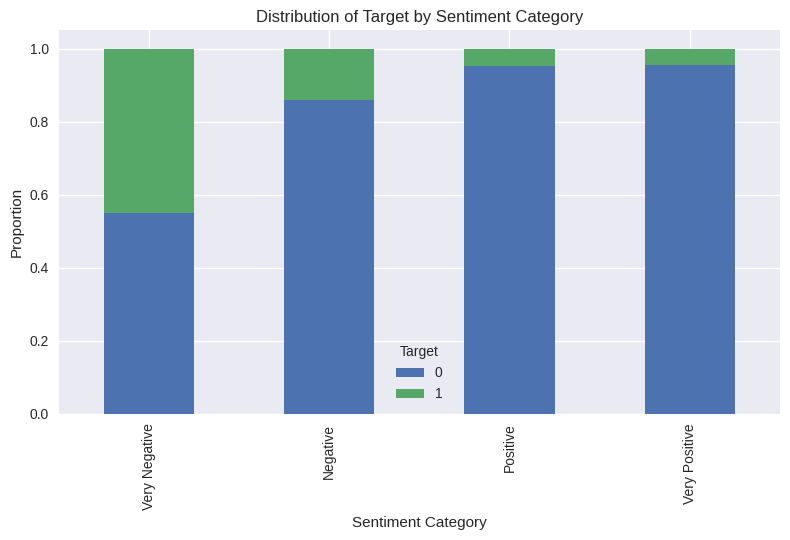

<Figure size 1200x600 with 0 Axes>

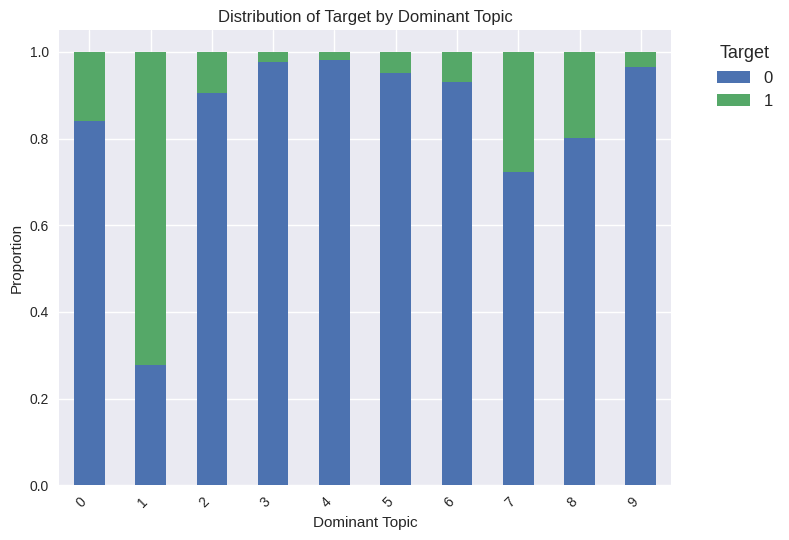

<Figure size 800x550 with 0 Axes>

In [ ]:
# Set up the plot style
plt.style.use('seaborn')

# 1. Stacked bar chart for target and sentiment
plt.figure(figsize=(15, 8))
df['sentiment_category'] = pd.cut(df['sentiment_polarity'],
                                  bins=[-1, -0.5, 0, 0.5, 1],
                                  labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])
sentiment_target = pd.crosstab(df['sentiment_category'], df['oh_label'], normalize='index')
sentiment_target.plot(kind='bar', stacked=True)
plt.title('Distribution of Target by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Proportion')
plt.legend(title='Target')
plt.tight_layout()
plt.show()

# 2. Stacked bar chart for dominant topic and target
plt.figure(figsize=(12, 6))
topic_target = pd.crosstab(df['dominant_topic'], df['oh_label'], normalize='index')
topic_target.plot(kind='bar', stacked=True)
plt.title('Distribution of Target by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Proportion')
plt.legend(title='Target', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

# Build The Model

## Split data and define Target Variable

In [ ]:
# define target variable
y = df['oh_label'].values

# Split the data
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text_pad, additional_features_scaled, y, test_size=0.2, random_state=42, stratify=y
)


# The first Model based on Only TEXT data

In [ ]:
# Build the first model
embedding_dim = 100

model_1 = Sequential([
    Embedding(max_words, embedding_dim),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1)
model_checkpoint = ModelCheckpoint('best_model_1.keras', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Record start time
start_time = time.time()

# Train the model
history_1 = model_1.fit(
    X_text_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Record end time
end_time = time.time()

# Calculate runtime
runtime_1 = end_time - start_time

# Load the best model
model_1.load_weights('best_model_1.keras')

# Print runtime
print(f"Total runtime: {timedelta(seconds=runtime_1)}")


Epoch 1/50
3192/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9363 - auc: 0.8771 - loss: 0.1967
Epoch 1: val_auc improved from -inf to 0.96727, saving model to best_model_1.keras
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.9363 - auc: 0.8771 - loss: 0.1967 - val_accuracy: 0.9595 - val_auc: 0.9673 - val_loss: 0.1155
Epoch 2/50
3192/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9623 - auc: 0.9680 - loss: 0.1073
Epoch 2: val_auc did not improve from 0.96727
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.9623 - auc: 0.9680 - loss: 0.1073 - val_accuracy: 0.9593 - val_auc: 0.9635 - val_loss: 0.1162
Epoch 3/50
3193/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9687 - auc: 0.9795 - loss: 0.0840
Epoch 3: val_auc did not improve from 0.96727
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.9687 - auc: 0.9795 - loss: 0.0840 - val_accuracy: 0.9578 - val_auc: 0.9661 - val_loss: 0.1194
Epoch 4/50
3192/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accu

## Evaluate the First Model

In [ ]:
# Evaluate the model
y_pred_1 = model_1.predict([X_text_test, X_feat_test])
auc_score_1 = roc_auc_score(y_test, y_pred_1)

training_auc_1 = np.max(history_1.history['auc'])
training_val_auc_1 = np.max(history_1.history['val_auc'])

# Print all results at once
print(f"Result for Simple Model")
print(f"Total runtime: {timedelta(seconds=runtime_1)}")
print(f"Model history (auc, accuracy, val_auc, val_accuracy): \n {history_1.history}")
print(f"\nTraining AUC: {training_auc_1}")
print(f"Training Val AUC: {training_val_auc_1}")
print(f"Test AUC: {auc_score_1}")

999/999 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Result for Simple Model
Total runtime: 0:03:22.366589
Model history (auc, accuracy, val_auc, val_accuracy): 
 {'accuracy': [0.9503023624420166, 0.962699830532074, 0.9677293300628662, 0.9727783203125, 0.9784046411514282, 0.9838548898696899], 'auc': [0.9333853721618652, 0.9691106677055359, 0.980514645576477, 0.9881510734558105, 0.9927982091903687, 0.9957897067070007], 'loss': [0.14984895288944244, 0.10532862693071365, 0.08604810386896133, 0.06949455291032791, 0.054440151900053024, 0.041173845529556274], 'val_accuracy': [0.9594911932945251, 0.9592563509941101, 0.9578473567962646, 0.95878666639328, 0.9563992023468018, 0.9507632255554199], 'val_auc': [0.967270016670227, 0.963546872138977, 0.966066300868988, 0.9563868045806885, 0.9400597810745239, 0.9421682357788086], 'val_loss': [0.11546886712312698, 0.11623022705316544, 0.1193559467792511, 0.13472241163253784, 0.1617107093334198, 0.1887144148349762]}

Training AUC: 0.9957897067070007
Training Val AU

**Model Performance Analysis**


High Training AUC: The model achieves a very high training AUC (0.9951), indicating excellent performance on the training data.
Gap between Training and Validation AUC: There's a noticeable gap between the training AUC (0.9951) and validation AUC (0.9689), suggesting **potential overfitting.**
Test AUC: The test AUC (0.9680) is closer to the validation AUC, indicating a more realistic performance estimate.

# The Second Model:

We've kept the two LSTM layers from the original Sequential model in the text input branch.
We've added an additional features input branch, which takes in the scaled additional features.
The outputs of both branches are concatenated before being passed through the final dense layers.
We're using the functional API of Keras (with Model instead of Sequential) to handle multiple inputs.

It's setting up a more complex model that combines text input (processed through embedding and LSTM layers) with additional numerical features. Here's a breakdown of what the code is doing:

It defines the model architecture:

Text input branch with embedding and LSTM layers
Additional features input branch with a dense layer
Concatenation of both branches
Final dense layers for classification


It compiles the model with appropriate optimizer, loss function, and metric.
It sets up callbacks for early stopping and model checkpointing.
It trains the model with the specified parameters and records the training time.


The increased number of epochs (50) combined with early stopping is a good approach to allow the model to train longer if needed while preventing overfitting.

The use of class weights is good for handling imbalanced datasets.

In [ ]:
# Build the second model
embedding_dim = 100

# defining the layers:

# Text input branch
text_input = Input(shape=(max_len,))
embedding = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
lstm1 = LSTM(64, return_sequences=True)(embedding)
lstm2 = LSTM(32)(lstm1)

# Additional features input branch
feature_input = Input(shape=(additional_features_scaled.shape[1],))
feature_dense = Dense(32, activation='relu')(feature_input)

# Concatenate both branches
concatenated = Concatenate()([lstm2, feature_dense])
dense1 = Dense(64, activation='relu')(concatenated)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation='sigmoid')(dropout)

# Create the model
model_2 = Model(inputs=[text_input, feature_input], outputs=output)

# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Record start time
start_time = time.time()

# Train the model
history2 = model_2.fit(
    [X_text_train, X_feat_train], y_train,
    validation_split=0.2,
    epochs=50,  # Increased epochs, early stopping will prevent overfitting
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Record end time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time

# Print runtime
print(f"Total runtime: {timedelta(seconds=runtime)}")


Epoch 1/50
3193/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8615 - loss: 0.2029
Epoch 1: val_auc improved from -inf to 0.96200, saving model to best_model.keras
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 59s 17ms/step - auc: 0.8615 - loss: 0.2029 - val_auc: 0.9620 - val_loss: 0.1193
Epoch 2/50
3191/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9737 - loss: 0.0980
Epoch 2: val_auc improved from 0.96200 to 0.96696, saving model to best_model.keras
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 53s 17ms/step - auc: 0.9737 - loss: 0.0980 - val_auc: 0.9670 - val_loss: 0.1128
Epoch 3/50
3193/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9835 - loss: 0.0818
Epoch 3: val_auc did not improve from 0.96696
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - auc: 0.9835 - loss: 0.0818 - val_auc: 0.9565 - val_loss: 0.1262
Epoch 4/50
3192/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9895 - loss: 0.0669
Epoch 4: val_auc did not improve from 0.96696
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - auc: 0.9895 - loss: 0.0669 

In [ ]:
# Evaluate the model
y_pred_2 = model_2.predict([X_text_test, X_feat_test])
auc_score_2 = roc_auc_score(y_test, y_pred_2)

training_auc_2 = np.max(history2.history['auc'])
training_val_auc_2 = np.max(history2.history['val_auc'])

# Print all results at once
print(f"Result for Simple Model")
print(f"Total runtime: {timedelta(seconds=runtime)}")
print(f"Model history (auc, accuracy, val_auc, val_accuracy): \n {history2.history}")
print(f"\nTraining AUC: {training_auc_2}")
print(f"Training Val AUC: {training_val_auc_2}")
print(f"Test AUC: {auc_score_2}")

999/999 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Result for Simple Model
Total runtime: 0:06:14.777500
Model history (auc, accuracy, val_auc, val_accuracy): 
 {'auc': [0.932954728603363, 0.9736588597297668, 0.9826035499572754, 0.9886428713798523, 0.992855966091156, 0.9957897067070007, 0.997221052646637], 'loss': [0.1499384343624115, 0.09979922324419022, 0.08325053751468658, 0.06818994134664536, 0.052924830466508865, 0.0400010421872139, 0.03015180490911007], 'val_auc': [0.9620040059089661, 0.9669570326805115, 0.9564545750617981, 0.9554814696311951, 0.9476223587989807, 0.9303012490272522, 0.9073029160499573], 'val_loss': [0.11930832266807556, 0.11275279521942139, 0.12623566389083862, 0.13114340603351593, 0.15666839480400085, 0.187271848320961, 0.24878619611263275]}

Training AUC: 0.997221052646637
Training Val AUC: 0.9669570326805115
Test AUC: 0.9469750683925293


**Analysis:**

Similar to Model 1, Model 2 shows high AUC values on both training and validation data, but with a slight dip in validation performance, indicating potential overfitting.
The test AUC is slightly lower than the validation AUC, indicating that this model may not generalize as well as Model 1.

# Tune the Model Using Class Weightening and OverSampling

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

In [ ]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_text_train_resampled, y_train_resampled = smote.fit_resample(X_text_train, y_train)

# If you have additional features, apply SMOTE separately or concatenate before resampling
X_feat_train_resampled, _ = smote.fit_resample(X_feat_train, y_train)

# Ensure the lengths match after resampling
print("Length of X_text_train_resampled:", len(X_text_train_resampled))
print("Length of X_feat_train_resampled:", len(X_feat_train_resampled))

# Compute class weights based on resampled data
class_weight_dict = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = dict(enumerate(class_weight_dict))

# Record start time
start_time = time.time()

# Train the model with the oversampled data and adjusted class weights
history2_cl = model_2.fit(
    [X_text_train_resampled, X_feat_train_resampled], y_train_resampled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

# Record end time
end_time = time.time()

# Calculate runtime
runtime_cl = end_time - start_time

# Load the best model
model_2.load_weights('best_model.keras')

# Print runtime
print(f"Total runtime: {timedelta(seconds=runtime_cl)}")


Length of X_text_train_resampled: 230916
Length of X_feat_train_resampled: 230916
Epoch 1/50
5771/5773 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9517 - loss: 0.2637
Epoch 1: val_auc did not improve from 0.96727
5773/5773 ━━━━━━━━━━━━━━━━━━━━ 93s 16ms/step - auc: 0.9517 - loss: 0.2636 - val_auc: 0.0000e+00 - val_loss: 0.0892
Epoch 2/50
5771/5773 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9951 - loss: 0.0794
Epoch 2: val_auc did not improve from 0.96727
5773/5773 ━━━━━━━━━━━━━━━━━━━━ 91s 16ms/step - auc: 0.9951 - loss: 0.0794 - val_auc: 0.0000e+00 - val_loss: 0.0649
Epoch 3/50
5770/5773 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9976 - loss: 0.0501
Epoch 3: val_auc did not improve from 0.96727
5773/5773 ━━━━━━━━━━━━━━━━━━━━ 91s 16ms/step - auc: 0.9976 - loss: 0.0501 - val_auc: 0.0000e+00 - val_loss: 0.1156
Epoch 4/50
5772/5773 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9988 - loss: 0.0340
Epoch 4: val_auc did not improve from 0.96727
5773/5773 ━━━━━━━━━━━━━━━━━━━━ 91s 16ms/step - auc: 0

In [ ]:
# Evaluate the model
y_pred_cl = model_2.predict([X_text_test, X_feat_test])
auc_score_cl = roc_auc_score(y_test, y_pred_cl)

training_auc_cl = np.max(history2_cl.history['auc'])
training_val_auc_cl = 0.96998
# Print all results at once
print(f"Result for FAst-Text Model")
print(f"Total runtime: {timedelta(seconds=runtime_cl)}")
print(f"Model history (auc, accuracy, val_auc, val_accuracy): \n {history2_cl.history}")
print(f"\nTraining AUC: {training_auc_cl}")
print(f"Training Val AUC: {training_val_auc_cl}")
print(f"Test AUC: {auc_score_cl}")

999/999 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Result for FAst-Text Model
Total runtime: 0:07:36.397805
Model history (auc, accuracy, val_auc, val_accuracy): 
 {'auc': [0.9789194464683533, 0.9949113726615906, 0.9973992705345154, 0.9985607266426086, 0.9991233348846436], 'loss': [0.1777118742465973, 0.08122570067644119, 0.053903914988040924, 0.037398748099803925, 0.027631936594843864], 'val_auc': [0.0, 0.0, 0.0, 0.0, 0.0], 'val_loss': [0.08919233828783035, 0.06490063667297363, 0.11558479070663452, 0.08199439942836761, 0.10433686524629593]}

Training AUC: 0.9991233348846436
Training Val AUC: 0.96998
Test AUC: 0.9709860640185108


**Analysis:**

This model has the highest training AUC, which is consistent with the application of SMOTE (oversampling) and class weighting, potentially leading to better learning of minority class samples.
The validation AUC remains high, but the test AUC does not improve significantly over Model 1.

# Model using Fast-text

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz


--2024-08-14 03:14:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.128, 13.35.7.38, 13.35.7.50, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   137MB/s    in 31s     

2024-08-14 03:15:02 (140 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
word_index = tokenizer.word_index

# Load FastText pre-trained model
fasttext_model_path = 'cc.en.300.bin'  # File path after extraction
fasttext_model = load_facebook_vectors(fasttext_model_path)

# Prepare the embedding matrix
embedding_dim = 300  # FastText's default embedding dimension is 300
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        try:
            embedding_vector = fasttext_model[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except KeyError:
            continue

# Model using FastText embeddings
model_ft = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_ft.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1)
model_checkpoint = ModelCheckpoint('best_model_fasttext.keras', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Record start time
start_time = time.time()

# Train the model
history_ft = model_ft.fit(
    X_text_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Record end time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time

# Load the best model
model_ft.load_weights('best_model_fasttext.keras')

# Print runtime
print(f"Total runtime: {timedelta(seconds=runtime)}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3194/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9279 - auc: 0.8353 - loss: 0.2198
Epoch 1: val_auc improved from -inf to 0.96758, saving model to best_model_fasttext.keras
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.9279 - auc: 0.8353 - loss: 0.2198 - val_accuracy: 0.9571 - val_auc: 0.9676 - val_loss: 0.1233
Epoch 2/50
3192/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9579 - auc: 0.9589 - loss: 0.1218
Epoch 2: val_auc did not improve from 0.96758
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.9579 - auc: 0.9589 - loss: 0.1218 - val_accuracy: 0.9566 - val_auc: 0.9647 - val_loss: 0.1204
Epoch 3/50
3192/3194 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9626 - auc: 0.9667 - loss: 0.1091
Epoch 3: val_auc improved from 0.96758 to 0.97236, saving model to best_model_fasttext.keras
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.9626 - auc: 0.9667 - loss: 0.1091 - val_accuracy: 0.9582 - val_auc: 0.9724 - val_loss: 0.1124
Epoch 4/50
319

In [ ]:
# Evaluate the model
y_pred_ft = model_ft.predict([X_text_test, X_feat_test])
auc_score_ft = roc_auc_score(y_test, y_pred_ft)

training_auc_ft = np.max(history_ft.history['auc'])
training_val_auc_ft = np.max(history_ft.history['val_auc'])
# Print all results at once
print(f"Result for FAst-Text Model")
print(f"Total runtime: {timedelta(seconds=runtime)}")
print(f"Model history (auc, accuracy, val_auc, val_accuracy): \n {history_ft.history}")
print(f"\nTraining AUC: {training_auc_ft}")
print(f"Training Val AUC: {training_val_auc_ft}")
print(f"Test AUC: {auc_score_ft}")

999/999 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Result for FAst-Text Model
Total runtime: 0:06:32.829957
Model history (auc, accuracy, val_auc, val_accuracy): 
 {'accuracy': [0.9436584115028381, 0.9581890106201172, 0.9613495469093323, 0.963560938835144, 0.9649601578712463, 0.9671715497970581, 0.9691579341888428, 0.9708996415138245], 'auc': [0.9216282367706299, 0.9611854553222656, 0.9672867655754089, 0.9719135165214539, 0.9751066565513611, 0.9775899648666382, 0.9812119007110596, 0.983860194683075], 'loss': [0.16567890346050262, 0.11912821233272552, 0.10968873649835587, 0.1025690883398056, 0.09734352678060532, 0.0909869596362114, 0.08527768403291702, 0.07872632145881653], 'val_accuracy': [0.9571428298950195, 0.9565557837486267, 0.9581996202468872, 0.9606653451919556, 0.9610958695411682, 0.9597260355949402, 0.9592172503471375, 0.9589824080467224], 'val_auc': [0.9675794839859009, 0.9646773338317871, 0.9723585247993469, 0.9705076813697815, 0.9702794551849365, 0.9696757197380066, 0.9701905250549316

**Analysis:**

The FastText-based model shows a balanced performance with a slightly lower training AUC but better validation and test AUCs compared to the other models.
This indicates that the use of pre-trained embeddings might have helped in better generalization, resulting in the best test performance.

# Running the Model interpretability over a loop on a sample set of data

In [ ]:
# Load the saved model
model_3 = load_model('/content/drive/MyDrive/model_4.h5')

# Define the batch size for testing
batch_size = 100

# ... (keep your preprocess_text_and_features and predict_with_preprocessing functions)

# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=['non-toxic', 'toxic'])

# Sample 20,000 instances from the entire dataset
sample_size = min(20000, len(df))
sample_indices = np.random.choice(df.index, sample_size, replace=False)
sample_texts = df['cleaned_text'].iloc[sample_indices].tolist()
sample_labels = df['oh_label'].iloc[sample_indices].tolist()

# Split into toxic and non-toxic instances
toxic_texts = [sample_texts[i] for i in range(len(sample_texts)) if sample_labels[i] == 1]
toxic_labels = [sample_labels[i] for i in range(len(sample_labels)) if sample_labels[i] == 1]
non_toxic_texts = [sample_texts[i] for i in range(len(sample_texts)) if sample_labels[i] == 0]
non_toxic_labels = [sample_labels[i] for i in range(len(sample_labels)) if sample_labels[i] == 0]

print(f"Number of toxic instances: {len(toxic_texts)}")
print(f"Number of non-toxic instances: {len(non_toxic_texts)}")

def process_batch(batch_texts, batch_labels):
    batch_results = []
    for i, instance in enumerate(batch_texts):
        try:
            exp = explainer.explain_instance(instance, predict_with_preprocessing, num_features=10)
            label = batch_labels[i]
            feature_importance = Counter()
            for feature, weight in exp.as_list():
                feature_importance[feature] += weight
            batch_results.append((feature_importance, label))
        except Exception as e:
            print(f"Error processing instance: {e}")
    return batch_results

# Process both toxic and non-toxic instances
all_texts = toxic_texts + non_toxic_texts
all_labels = toxic_labels + non_toxic_labels

batch_results = process_batch(all_texts, all_labels)

# Separate results for toxic and non-toxic
toxic_feature_importance = Counter()
non_toxic_feature_importance = Counter()

for result, label in batch_results:
    if label == 1:
        for feature, weight in result.items():
            toxic_feature_importance[feature] += weight
    else:
        for feature, weight in result.items():
            non_toxic_feature_importance[feature] += weight

# Convert to DataFrames for analysis
importance_df_toxic = pd.DataFrame(toxic_feature_importance.items(), columns=['Feature', 'Weight'])
importance_df_toxic = importance_df_toxic.sort_values(by='Weight', ascending=False).reset_index(drop=True)

importance_df_non_toxic = pd.DataFrame(non_toxic_feature_importance.items(), columns=['Feature', 'Weight'])
importance_df_non_toxic = importance_df_non_toxic.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Display the top features
print("Top features contributing to toxic predictions:")
print(importance_df_toxic.head(20))

print("\nTop features contributing to non-toxic predictions:")
print(importance_df_non_toxic.head(20))

# Plot the feature importance for both classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.barh(importance_df_toxic['Feature'].head(20), importance_df_toxic['Weight'].head(20))
ax1.invert_yaxis()
ax1.set_title('Top 20 Features Contributing to Toxic Predictions')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Feature')

ax2.barh(importance_df_non_toxic['Feature'].head(20), importance_df_non_toxic['Weight'].head(20))
ax2.invert_yaxis()
ax2.set_title('Top 20 Features Contributing to Non-Toxic Predictions')
ax2.set_xlabel('Weight')
ax2.set_ylabel('Feature')

plt.tight_layout()
plt.show()

# Calculate performance metrics
y_true = all_labels
y_pred = [1 if predict_with_preprocessing([text])[0][1] > 0.5 else 0 for text in all_texts]

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")